In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# import CSVs into dataframe
df1 = pd.read_csv("/home/jovyan/capstone/PSE_meter_23-24.csv",skiprows=5)
df2 = pd.read_csv("/home/jovyan/capstone/PSE_meter_24-25.csv",skiprows=5)
df = pd.concat([df1, df2], axis=0)

# set index to date + time
df['datetime'] = pd.to_datetime(df['DATE'] + ' ' + df['START TIME'])
df = df.set_index('datetime')

# remove unnecessary columns and duplicate rows from dataframe and print first few rows
df = df[['USAGE (kWh)', 'DEMAND (kW)']]
df = df[~df.index.duplicated(keep='first')]
print(df.head())

                     USAGE (kWh)  DEMAND (kW)
datetime                                     
2023-10-10 00:00:00         0.87         3.48
2023-10-10 00:15:00         0.83         3.34
2023-10-10 00:30:00         0.79         3.14
2023-10-10 00:45:00         0.81         3.24
2023-10-10 01:00:00         0.82         3.28


In [3]:
# check for meter downtimes
meter_down = df.index.to_series().diff()
print(meter_down[meter_down > pd.Timedelta('15min')])

datetime
2024-03-10 03:15:00   0 days 01:15:00
2024-08-24 05:15:00   0 days 19:15:00
2025-03-09 03:15:00   0 days 01:15:00
Name: datetime, dtype: timedelta64[ns]


In [4]:
# define uniform time base with NaN during downtimes
full_index = pd.date_range(start=df.index.min(),end=df.index.max(),freq='15min')
df = df.reindex(full_index)

In [5]:
# understand differences between power from energy and total demand to evaulate reliability of meter
df['power_from_energy'] = df['USAGE (kWh)'] / 0.25
df['demand_diff'] = df['DEMAND (kW)'] - df['power_from_energy']
print(df['demand_diff'].describe())
print('Correlation:', df['DEMAND (kW)'].corr(df['power_from_energy']))

count    68556.000000
mean        -0.002068
std          0.014284
min         -1.800000
25%         -0.010000
50%          0.000000
75%          0.010000
max          0.210000
Name: demand_diff, dtype: float64
Correlation: 0.9999656072776482


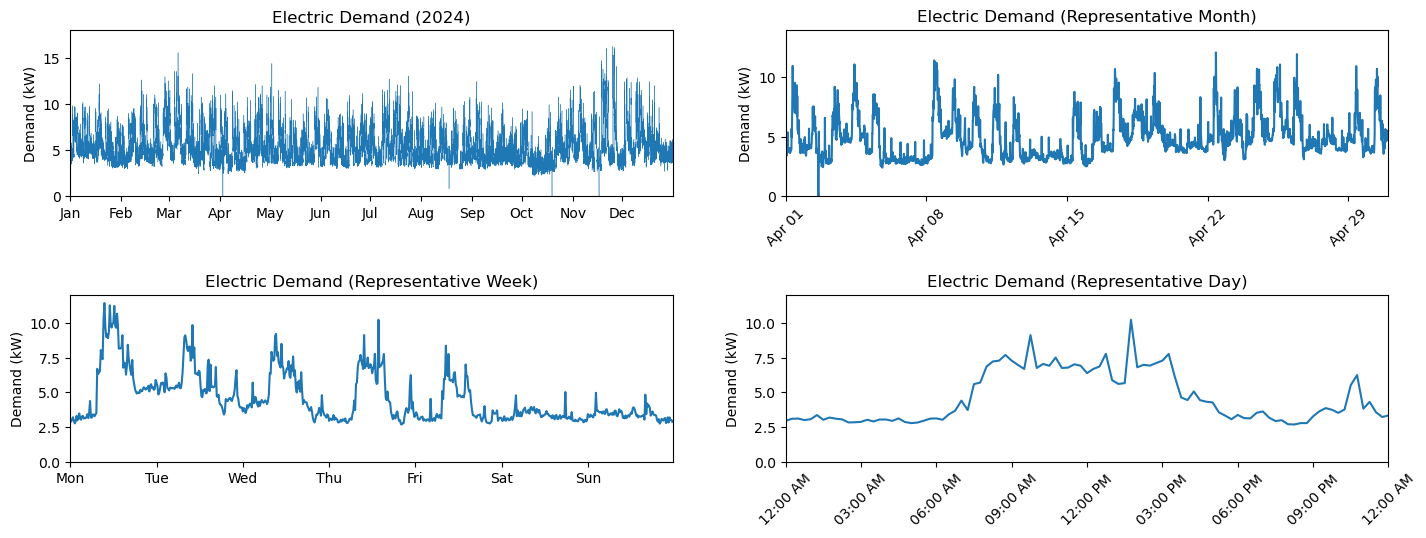

In [6]:
# Create 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(15, 6))
fig.tight_layout(pad=5)

# --- 1. Full year plot ---
ax = axs[0, 0]
ax.plot(df.loc['2024'].index, df.loc['2024']['DEMAND (kW)'], linewidth=0.3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_xlim(pd.Timestamp('2024-01-01 00:00:00'), pd.Timestamp('2024-12-31 23:45:00'))
ax.set_ylim(0, 18)
ax.set_ylabel("Demand (kW)")
ax.set_title("Electric Demand (2024)")

# --- 2. Representative month (April 2024) ---
ax = axs[0, 1]
ax.plot(df.loc['2024-04'].index, df.loc['2024-04']['DEMAND (kW)'])
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=pd.Timestamp('2024-04-01').weekday(), interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_xlim(pd.Timestamp('2024-04-01 00:00:00'), pd.Timestamp('2024-04-30 23:45:00'))
ax.set_ylim(0, 14)
ax.set_ylabel("Demand (kW)")
ax.set_title("Electric Demand (Representative Month)")
plt.setp(ax.get_xticklabels(), rotation=45)

# --- 3. Representative week (April 8-14, 2024) ---
ax = axs[1, 0]
ax.plot(df.loc['2024-04-08':'2024-04-14'].index, df.loc['2024-04-08':'2024-04-14']['DEMAND (kW)'])
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))
ax.set_xlim(pd.Timestamp('2024-04-08 00:00:00'), pd.Timestamp('2024-04-14 23:45:00'))
ax.set_ylim(0, 12)
ax.set_ylabel("Demand (kW)")
ax.set_title("Electric Demand (Representative Week)")

# --- 4. Representative day (April 11, 2024) ---
ax = axs[1, 1]
ax.plot(df.loc['2024-04-11':'2024-04-12 00:00:00'].index, df.loc['2024-04-11':'2024-04-12 00:00:00']['DEMAND (kW)'])
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%I:%M %p'))
ax.set_xlim(pd.Timestamp('2024-04-11 00:00:00'), pd.Timestamp('2024-04-12 00:00:00'))
ax.set_ylim(0, 12)
ax.set_ylabel("Demand (kW)")
ax.set_title("Electric Demand (Representative Day)")
plt.setp(ax.get_xticklabels(), rotation=45);

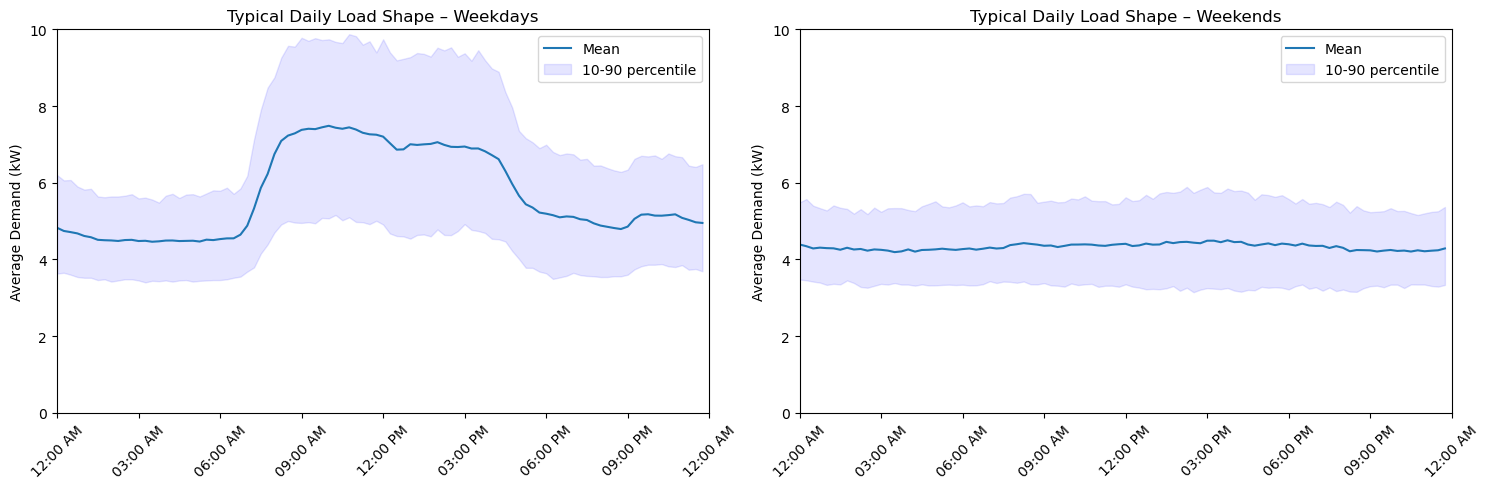

In [7]:
# tag weekdays and weekends
df['is_weekend'] = df.index.weekday >= 5  # Sat=5, Sun=6

# Hour of day 
df['hour'] = df.index.hour + df.index.minute/60

# Weekdays
wd = df[~df['is_weekend']]
wd_group = wd.groupby('hour')['DEMAND (kW)']
wd_mean = wd_group.mean()
wd_q10 = wd_group.quantile(0.1)
wd_q90 = wd_group.quantile(0.9)

# Weekends
we = df[df['is_weekend']]
we_group = we.groupby('hour')['DEMAND (kW)']
we_mean = we_group.mean()
we_q10 = we_group.quantile(0.1)
we_q90 = we_group.quantile(0.9)

# convert hour to datetime
hours_dt = pd.to_datetime(wd_mean.index, unit='h', origin=pd.Timestamp('2024-04-11'))

# plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.tight_layout(pad=5)

# --- Weekdays ---
ax = axs[0]
ax.plot(hours_dt, wd_mean.values, label='Mean')
ax.fill_between(hours_dt, wd_q10.values, wd_q90.values, color='blue', alpha=0.1, label='10-90 percentile')
ax.set_title("Typical Daily Load Shape – Weekdays")
ax.set_ylabel("Average Demand (kW)")
ax.legend()

# --- Weekends ---
ax = axs[1]
ax.plot(hours_dt, we_mean.values, label='Mean')
ax.fill_between(hours_dt, we_q10.values, we_q90.values, color='blue', alpha=0.1, label='10-90 percentile')
ax.set_title("Typical Daily Load Shape – Weekends")
ax.set_ylabel("Average Demand (kW)")
ax.legend()

for ax in axs:
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%I:%M %p'))
    ax.set_xlim(pd.Timestamp('2024-04-11 00:00:00'),
                pd.Timestamp('2024-04-12 00:00:00'))
    ax.set_ylim(0, 10)
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [17]:
# restrict to 2024
df_2024 = df.loc['2024']

# total annual energy (kWh)
annual_energy_kwh = (df_2024['DEMAND (kW)'] * 0.25).sum()

print(f'Total energy from electicity used in 2024: {annual_energy_kwh:.2f} kWh')

Total energy from electicity used in 2024: 44289.44 kWh
